# CH6 - 商業應用範例

In [1]:
# 載入常用套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 6-1: 顧客價值管理 (Custormer Value Management)

## 6-1-1. RFM理論 (Recency, Frequency, Monetory)

請參考PPT

### 1. 載入資料與前處理

### 雜貨店的銷售資料

只要有三個關鍵的欄位：售價、數量與日期，就可以結合RFM理論做到顧客價值管理。

In [2]:
purchase = pd.read_table('dataset/purchases.txt', header=None)
purchase.columns=['id','amount','date']
purchase = purchase.sort_values('date', axis=0, ascending=True)
purchase

,id,amount,date
17480,8150,20.0,2005-01-02
24329,10210,20.0,2005-01-02
7293,5540,100.0,2005-01-02
17048,14140,20.0,2005-01-04
34629,5640,30.0,2005-01-04
...,...,...,...
33843,187870,45.0,2015-12-31
7171,215270,20.0,2015-12-31
16123,263610,100.0,2015-12-31
39626,196020,80.0,2015-12-31


In [3]:
purchase['date'] = pd.to_datetime(purchase['date'])
purchase.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51243 entries, 17480 to 49307
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      51243 non-null  int64         
 1   amount  51243 non-null  float64       
 2   date    51243 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.6 MB


In [4]:
purchase.amount.describe()

count    51243.000000
mean        62.337195
std        156.606801
min          5.000000
25%         25.000000
50%         30.000000
75%         60.000000
max       4500.000000
Name: amount, dtype: float64

有多少不一樣的顧客：

In [5]:
purchase['id'].nunique()

18417

訂單在不同年份的數量分佈：

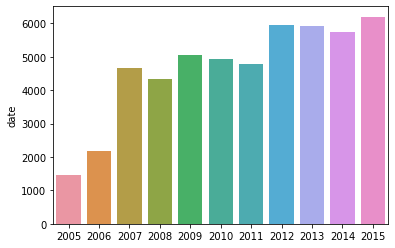

In [6]:
import datetime
year = purchase['date'].dt.strftime('%Y')
sns.barplot(x=year.value_counts().index, y=year.value_counts())
plt.show()

### 2. 計算RFM指標

由於此資料是從2005~2015結束，因此我們假設資料分析的觀察日為2016/01/01，並以該日當作RFM指標計算天數的基期。

In [7]:
# 計算天數
purchase['days'] = (datetime.datetime.strptime('2016-01-01', '%Y-%m-%d') - purchase['date']).dt.days
# 計算RFM
rfm = purchase.groupby(by=['id']).agg(
    # 最近一次消費時間距離今天(2016/01/01)的天數
    recency=('days', min),
    # 購買次數
    frequency=('id', 'size'),
    # 平均消費金額
    monetary=('amount', 'mean'),
    # 第一次消費時間距離今天的天數
    senior=('days', max),
    # 第一次消費日期
    since=('date', min)
)
rfm['log_monetary'] = np.log(rfm['monetary'])
rfm

,recency,frequency,monetary,senior,since,log_monetary
id,,,,,,
10,3829,1,30.000000,3829,2005-07-08,3.401197
80,343,7,71.428571,3751,2005-09-24,4.268698
90,758,10,115.800000,3783,2005-08-23,4.751865
120,1401,1,20.000000,1401,2012-03-01,2.995732
130,2970,2,50.000000,3710,2005-11-04,3.912023
...,...,...,...,...,...,...
263820,1,1,10.000000,1,2015-12-31,2.302585
263870,135,1,50.000000,135,2015-08-19,3.912023
263880,34,1,20.000000,34,2015-11-28,2.995732


RFM指標的敘述性統計：

In [8]:
rfm.describe()

,recency,frequency,monetary,senior,log_monetary
count,18417.000000,18417.000000,18417.000000,18417.000000,18417.000000
mean,1253.037900,2.782375,57.792985,1984.009882,3.582192
std,1081.437868,2.936888,154.360109,1133.405441,0.767593
min,1.000000,1.000000,5.000000,1.000000,1.609438
25%,244.000000,1.000000,21.666667,988.000000,3.075775
50%,1070.000000,2.000000,30.000000,2087.000000,3.401197
75%,2130.000000,3.000000,50.000000,2992.000000,3.912023
max,4014.000000,45.000000,4500.000000,4016.000000,8.411833


RFM分佈視覺化：

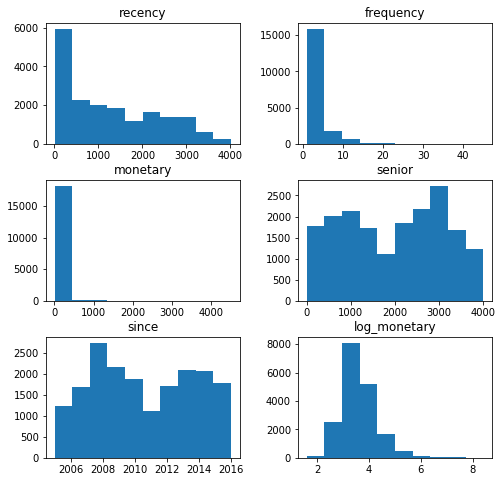

In [9]:
rfm.hist(bins=10,figsize=(8,8),grid=False)
plt.show()

+ Recency (R)：
    + 愈小表示顧客最近有來消費，愈大則代表很久沒來光顧。
    + 因左比右高，代表一直有顧客來消費。
+ Frequency (F)： 
    + 愈大表示顧客很常光顧。
    + 整體而言，消費次數多落在1次左右，而消費過10次的人也有，表示有忠實顧客群。
+ Monetary (M)：
    + 金錢相關的變數通常會呈現極度右偏狀態，因此一般都會取log，使其接近常態分佈。
    + 將x*10即能轉換成原始消費數字，因此，消費金額多落在30元左右(1：10元, 1.5：30元, 2：100元, 2.5：300元, 3：1000元, 3.5：3000元)。
+ Seniority：
    + 愈小是新進顧客，愈大則是老顧客。
    + 間隔時間會受到第一次消費日期影響，愈短不一定代表是只進行一次性消費的顧客，可能會包含持續消費的顧客。
    + 若要分析是否為忠誠顧客，必須考慮到消費頻率。

## 6-1-2: 顧客分群 (Customer Segamentation)

### 1. 資料前處理

In [10]:
# 為避免分群產生誤差，進行單位的標準化
from sklearn import preprocessing
scaled_data = preprocessing.scale(rfm.loc[:,['recency','frequency','monetary']])
rfm_scale = pd.DataFrame(scaled_data, columns = ['recency','frequency','monetary'])

### 2. 分群

In [11]:
# 利用Kmeans分群
from sklearn.cluster import KMeans

model = KMeans(n_clusters=10, random_state=2021).fit(rfm_scale)
rfm['Labels'] = model.labels_ # 將分群結果加入變數
rfm['Labels'].value_counts().sort_index()

0    2979
1    4149
2    1282
3     168
4      49
5      13
6    3232
7     140
8    2383
9    4022
Name: Labels, dtype: int64

### 3. 將分群結果套用RFM理論

依據分群結果計算每群的RFM指標：

In [12]:
rfm_clust = rfm.groupby(by=['Labels']).agg(
    # 每群平均recency
    recency=('recency', 'mean'),
    # 每群平均frequency
    frequency=('frequency', 'mean'),
    # 每群平均monetary
    monetary=('monetary', 'mean'),
    # 每群size
    size=('Labels', 'size')
)
rfm_clust['revenue'] = rfm_clust['size']*rfm_clust['monetary']/1000
rfm_clust

,recency,frequency,monetary,size,revenue
Labels,,,,,
0,3047.154750,1.193353,35.601753,2979,106.057623
1,231.843577,1.651723,49.253415,4149,204.352420
2,271.763651,9.779251,61.831826,1282,79.268401
3,793.839286,2.636905,720.266991,168,121.004854
4,1380.693878,2.408163,1796.732012,49,88.039869
5,783.230769,2.307692,3603.365385,13,46.843750
6,2127.383663,1.926361,37.254328,3232,120.405988
7,185.757143,19.057143,50.699875,140,7.097983
8,418.183382,5.336551,53.177263,2383,126.721417


### 4. 顧客分群分析 (泡泡圖)

+ x軸：Frequency，愈靠右邊代表該群愈常來消費。
+ y軸：Average Transaction Amount，愈靠上方代表該群平均消費金額愈大。
+ 泡泡大小：營收貢獻，泡泡愈大代表該群消費金額愈大。
+ 泡泡數字：群的大小，數字愈大代表愈多人屬於該群。
+ 泡泡顏色：Recency，愈偏向黃色代表該群顧客很久沒來消費了。

因此，我們通常希望愈多群具備以下特徵：
+ 靠近右上角。
+ 顏色愈紫(愈深)。
+ 泡泡愈大。
+ 數字愈大愈好。

In [13]:
# !pip install plotly
import plotly.express as px

rfm_clust['cluster'] = rfm_clust.index
fig = px.scatter(rfm_clust, x="frequency", y="monetary", size="revenue", color="recency",
                 hover_name="cluster", log_x=True, log_y=True, size_max=50,
                 text="size", title="Customer Segements",
                 labels={ "frequency": "Frequency (log)", "monetary": "Average Transaction Amount (log)", "recency": "Recency"})
fig.show()

+ 左下角【群0】黃色代表超久沒來消費，為【沉睡顧客】，共有2979人，是我們不樂見的。
+ 右下角【群7】的營收貢獻最小，但是為最經常來消費的族群，可能為【新潛力顧客】，應好好培養，讓其成為主力顧客。
+ 最上方【群5】,【群4】和【群3】的人數不多，但平均消費金額最多($3603,$1796,720)，是我們的【核心顧客】。
+ 左下角【群1】和【群9】的泡泡最大，對公司的營收貢獻最多，是我們的【主力顧客】，但其頻率不夠大，應輔佐其往右發展。
+ 【群6】為橘色，代表距離上次購買已經有一段時間，為【瞌睡顧客】，對他們可以實行優惠券行銷策略來喚醒他們，使其再來消費。
+ 【群2】和【群8】的頻率次高，距離上次購買的時間也很近，但是消費金額不夠高，可能為【一般新顧客】，應試圖將其往上拉發展成核心顧客。

## 6-1-3. 顧客終身價值 (Custormer Lifetime Value, CLV)

我們將使用既有的CLV套件來進行分析。<br>
套件說明文件：https://lifetimes.readthedocs.io/en/latest/index.html 。<br>
參考範例：https://lifetimes.readthedocs.io/en/latest/Quickstart.html 。

In [14]:
# 安裝套件
# !pip install lifetimes

### 1. 資料前處理

這個套件有一個很方便的功能'summary_data_from_transaction_data'，可以幫我們自動計算出 R, F 跟 senior。<br>
然而他的 R, F 計算方式跟我們前面使用的定義有些微不同，這並無對錯，同學可依據情境所需選擇最適的方案。<br>
+ R：顧客最後一次消費與第一次消費之間的天數差。
    + 我們的計算方式：顧客最後一次消費距離觀察日的天數差。
+ F：先將按「時間段」分組，再依據顧客ID計算次數。因此，若有顧客在同一天消費多次，則只會記為一次。
    + 我們的計算方式：只要有消費紀錄就記一次。
+ senior：與我們無異。

In [15]:
from lifetimes.utils import summary_data_from_transaction_data
summary = summary_data_from_transaction_data(purchase,
                                             customer_id_col = 'id',
                                             datetime_col = 'date',
                                             observation_period_end='2016-01-01')

summary

,frequency,recency,T
id,,,
10,0.0,0.0,3829.0
80,6.0,3408.0,3751.0
90,9.0,3025.0,3783.0
120,0.0,0.0,1401.0
130,1.0,740.0,3710.0
...,...,...,...
263820,0.0,0.0,1.0
263870,0.0,0.0,135.0
263880,0.0,0.0,34.0


對比我們的計算結果：

In [16]:
rfm[['recency','frequency','senior']]

,recency,frequency,senior
id,,,
10,3829,1,3829
80,343,7,3751
90,758,10,3783
120,1401,1,1401
130,2970,2,3710
...,...,...,...
263820,1,1,1
263870,135,1,135
263880,34,1,34


### 2. 預測顧客未來再次購買的頻率

這裡，我們將使用lifetimes套件計算的 R, F 結果進行分析。<br>
同學有興趣的話，也可以代入我們前面做的資料(rfm)進入模型，並觀察看看有什麼差別。

#### 建立BG/NBD模型

+ 常見參數：
    + penalizer_coef：是L2正規化(懲罰)的係數。預設為0 (亦即沒有懲罰)。
        + 對於較小的樣本量，參數可能會變得過大。
        + 有可能會使模型無法收斂。
        + 在典型的應用中，0.001~0.1的懲罰係數是有效的。

參考說明：https://lifetimes.readthedocs.io/en/latest/lifetimes.fitters.html#module-lifetimes.fitters.beta_geo_fitter 。

In [17]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter() # 演算法
bgf.fit(summary['frequency'], summary['recency'], summary['T']) # 餵入RF和senior的資料到模型
bgf.summary # 查看模型參數

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.594869,0.010923,0.573461,0.616278
alpha,575.974986,13.370058,549.769673,602.180299
a,0.236240,0.028278,0.180814,0.291665
b,2.316554,0.368867,1.593574,3.039534


#### Frequency/Recency矩陣圖

該矩陣可根據顧客的Recency和頻率，來計算該顧客在下一個時間段內的預期交易次數。

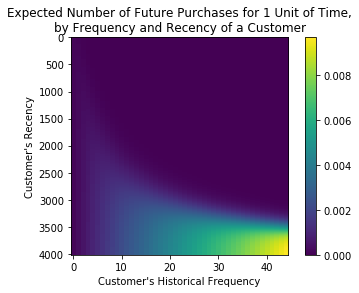

In [18]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf) 

我們可以看到，如果某個顧客購買了40次以上，並且最近一次購買是在他們3500天以內的時候，他們就是我們的最佳顧客(右下角)。<br>
我們的沉睡顧客在右上角，他們很快就買了很多東西，並且有很長一段時間沒有見到他們了。<br>
在(10,2500)周圍有一個「尾巴」，這些人不常來消費，他們有可能會再次購買，但我們不確定他們是已經沉睡，還是只是處在兩次消費的期間。

#### 顧客活躍的機率圖

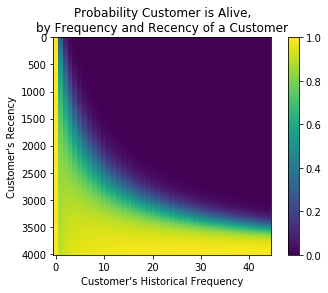

In [19]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

#### 預估在未來任意時間段內的預期購買次數

In [20]:
t = 365 # 選定要預測的時間範圍(天)
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])
summary.sort_values(by='predicted_purchases', ascending=False).head(5)

,frequency,recency,T,predicted_purchases
id,,,,
109370,40.0,2612.0,2613.0,4.561210
223470,13.0,489.0,546.0,4.141597
232340,10.0,303.0,330.0,3.990106
235590,9.0,294.0,302.0,3.739248
9720,44.0,3802.0,3831.0,3.633806


編號109370的顧客在接下來的365天內的預期購買次數為4~5次。

#### 評估模型的正確性

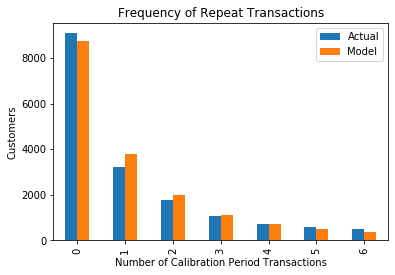

In [21]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

我們可以將數據集分為校準期數據集和保留數據集。<br>
這一點很重要，因為我們要測試模型如何處理尚未看到的數據。

In [22]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(purchase, 'id', 'date',
                                        calibration_period_end='2015-01-01',  # 期初
                                        observation_period_end='2016-01-01' ) # 期末
print(summary_cal_holdout.head())

     frequency_cal  recency_cal   T_cal  frequency_holdout  duration_holdout
id                                                                          
10             0.0          0.0  3464.0                0.0             365.0
80             5.0       3084.0  3386.0                1.0             365.0
90             9.0       3025.0  3418.0                0.0             365.0
120            0.0          0.0  1036.0                0.0             365.0
130            1.0        740.0  3345.0                0.0             365.0


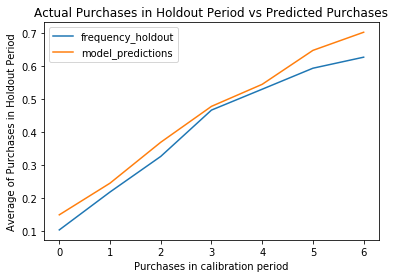

In [23]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

可以看到我們的模型都會稍微高估一些。

### 3. 預測顧客的CLV

#### 建立Gamma-Gamma模型

我們將用Gamma-Gamma模型來估計顧客的CLV，然而該模型有一個重要的假設：貨幣價值與購買頻率之間沒有關係。<br>
因此在使用前，我們必須先檢查兩個變數之間的相關性是否接近0才能使用此模型。

參考說明：https://lifetimes.readthedocs.io/en/latest/lifetimes.fitters.html#module-lifetimes.fitters.gamma_gamma_fitter 。

In [24]:
rfm[['monetary', 'frequency']].corr()

,monetary,frequency
monetary,1.000000,0.027892
frequency,0.027892,1.000000


#### 顧客平均預期獲利

In [25]:
from lifetimes import GammaGammaFitter

retain = rfm[rfm['frequency']>0] # 篩出購買一次以上的回購顧客
ggf = GammaGammaFitter()
ggf.fit(retain['frequency'], retain['monetary'])
ggf.conditional_expected_average_profit(rfm['frequency'], rfm['monetary'])

id
10         32.621467
80         70.966470
90        114.806983
120        23.946358
130        49.984838
             ...    
263820     15.271249
263870     49.971685
263880     23.946358
263890     53.441729
264200    440.351595
Length: 18417, dtype: float64

In [26]:
print("Average profit: %s" % (rfm[rfm['frequency']>0]['monetary'].mean()) )

Average profit: 57.79298510181551


#### 計算顧客CLV

使用財務中DCF(Discounted Cash Flow)分析法來計算CLV，需要有未來值(由BGF模型得到)和評估值(以GGF模型評估)。

In [27]:
bgf = BetaGeoFitter(penalizer_coef = 0.001).fit(rfm['frequency'], rfm['recency'], rfm['senior'])

print(ggf.customer_lifetime_value(
    bgf,
    rfm['frequency'],
    rfm['recency'],
    rfm['senior'],
    rfm['monetary'],
    time=12, # 月份
    discount_rate=0.01 # 每月調整後的折現率(默認0.01)
).head(10))

id
10     2.709084
80     0.000012
90     0.000076
120    5.264835
130    7.178137
160    4.767149
190    9.653067
220    2.940989
230    3.990448
240    0.005137
Name: clv, dtype: float64
